<div class="image-container">
  <img class="image" src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Logo-ITESO-Vertical-SinFondo-png.png" width="300" height="300" style="float: right">
</div>


<p>
    <font style = "font-family:Cambria">          
    <h2><font color="#191970" size = 6 >
        001 Modelo de Puntuación crediticia
    </font></h2>         
    <br>         
    <font color='navy' size = 6>Project 1. </font>
    <br> 
    <h3><font size =4>Collaborators:</font></h3> 
    <ul>
        <li>Diego Emilio Enriquez Nares</li>
        <li>Ana Sofia Brizuela Casarin</li>
        <li>Juan Antonio Mugica Liparoli</li>
    </ul>               
    </font>
</p>

In [17]:
# LIBRARIES
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

warnings.filterwarnings("ignore")



In [34]:
class CreditScoreModel:
    def __init__(self, filepath):
        # Load the CSV file
        self.df = pd.read_csv(filepath)
        self.bins = [-1, 290, 530, 852]  # Default bins used for scoring
        self.columns_to_process_num = []  # Placeholder for numeric columns to bin

    # Data cleaning and transformation method
    def clean_and_transform(self):
        # Replace null values
        null_columns = ['Occupation', 'Changed_Credit_Limit', 'Payment_Behaviour', 'Credit_Mix']
        hyphen_columns = ['Age', 'Num_of_Loan', 'Annual_Income', 'Num_of_Delayed_Payment',
                          'Outstanding_Debt', 'Changed_Credit_Limit', 'Amount_invested_monthly',
                          'Monthly_Balance']
        credit_mapping = {'Good': 1, 'Standard': 0, 'Bad': -1, 'Poor': -1}
        payment_min_amount_mapping = {'No': 1, 'Yes': -1, 'NM': 0}
        payment_behaviour_mapping = {
            'High_spent_Small_value_payments': 1, 'Low_spent_Large_value_payments': 5,
            'Low_spent_Medium_value_payments': 4, 'Low_spent_Small_value_payments': 3,
            'High_spent_Medium_value_payments': 2, 'High_spent_Large_value_payments': 6
        }
        
        # Transform the 'Credit_History_Age' column
        self.df['Credit_History_Age_Num'] = self.df['Credit_History_Age'].apply(self.convert_to_numeric)
        
        # Clean specific columns
        for column in null_columns:
            self.replace_with_nulls(column)
        for column in hyphen_columns:
            self.clean_hyphen_columns(column)
        
        # Map categorical columns
        self.df['Credit_Mix_Num'] = self.df['Credit_Mix'].map(credit_mapping)
        self.df['Credit_Score_Num'] = self.df['Credit_Score'].map(credit_mapping)
        self.df['Payment_min_amount_Num'] = self.df['Payment_of_Min_Amount'].map(payment_min_amount_mapping)
        self.df['Payment_Behaviour_Num'] = self.df['Payment_Behaviour'].map(payment_behaviour_mapping)
        
        # Create new columns
        self.df = self.df.dropna()
        self.df['Num_Types_of_Loans'] = self.df['Type_of_Loan'].apply(lambda x: x.count(',') + 1 if x not in ['not specified', 'No Data'] else 0)
        self.df['Q_Types_Of_Credits'] = self.df['Num_Credit_Card'] + self.df['Num_of_Loan'] + self.df['Credit_Mix_Num'] + self.df['Num_Types_of_Loans']
        self.df['Payment_History'] = -self.df['Delay_from_due_date'] - self.df['Num_of_Delayed_Payment']
        
        # Drop unnecessary columns
        columns_to_drop = ['ID', 'Customer_ID', 'Name', 'Credit_Mix', 'Payment_of_Min_Amount', 
                           'Payment_Behaviour', 'Type_of_Loan', 'Credit_History_Age']
        self.df = self.df.drop(columns=columns_to_drop)
    
    # Helper methods
    def convert_to_numeric(self, text):
        if pd.isnull(text):
            return None
        parts = re.findall(r'(\d+)\sYears and\s(\d+)\sMonths', text)
        if parts:
            years, months = map(int, parts[0])
            return years + months / 12
        return None

    def replace_with_nulls(self, column):
        values_to_replace = ['_______', '!@9#%8', '_']
        self.df[column] = self.df[column].apply(lambda x: np.nan if x in values_to_replace else x)

    def clean_hyphen_columns(self, column):
        self.df[column] = self.df[column].replace(r'^_+|_+$', '', regex=True).astype(float)

    # Method to apply scoring logic and print outputs
    def apply_scoring(self):
        # Scoring conditions
        v_sup, v_ssup, v_tsup, v_usup = 128, 128 / 4 * 3, 128 / 4 * 2, 128 / 4
        v_sup_, v_ssup_, v_tsup_ = 170, 170 / 4 * 3, 170 / 4 * 2

        conditions = {
            'Num_Credit_Card': lambda x: v_sup if x <= 2 else v_ssup if x <= 4 else v_tsup if x <= 6 else v_usup if x <= 8 else 0,
            'Interest_Rate': lambda x: v_sup_ if x < 5 else 0 if x > 20 else v_tsup_,
            'Delay_from_due_date': lambda x: v_sup if x < 5 else 0 if x > 31 else v_tsup,
            'Num_Credit_Inquiries': lambda x: v_sup if x < 0 else v_ssup if x <= 2 else v_tsup if x <= 5 else v_usup if x <= 8 else 0,
            'Outstanding_Debt': lambda x: v_sup if x < 0 else v_ssup if x < 500 else v_tsup if x < 1000 else v_usup if x < 1500 else 0,
            'Credit_Mix_Num': lambda x: v_sup_ if x == 1 else 0 if x == -1 else v_tsup_,
        }
        
        # Apply conditions and calculate the score
        self.df['Puntuation'] = self.df.apply(lambda row: sum(conditions[col](row[col]) for col in conditions), axis=1)
        
        # Assign categories based on the score
        self.df['Our_model'] = self.df['Puntuation'].apply(lambda x: 1 if x >= self.bins[2] else (-1 if x <= self.bins[1] else 0))
        
        # Calculate accuracy
        accuracy = (self.df['Our_model'] == self.df['Credit_Score_Num']).mean()
        print(f"Accuracy: {accuracy * 100:.1f}%")
        
        # Confusion matrix
        conf_matrix = confusion_matrix(self.df['Credit_Score_Num'], self.df['Our_model'])
        conf_matrix_df = pd.DataFrame(conf_matrix, index=[-1, 0, 1], columns=[-1, 0, 1])
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
        # Density plot
        plt.figure(figsize=(12, 6))
        sns.kdeplot(self.df[self.df['Credit_Score_Num'] == -1]['Puntuation'], label='Bad', fill=True)
        sns.kdeplot(self.df[self.df['Credit_Score_Num'] == 0]['Puntuation'], label='Standard', fill=True)
        sns.kdeplot(self.df[self.df['Credit_Score_Num'] == 1]['Puntuation'], label='Good', fill=True)
        plt.axvline(self.bins[1], color='k', linestyle='--', label='Best b1')
        plt.axvline(self.bins[2], color='k', linestyle='--', label='Best b2')
        plt.title('Density Plot of Overall Credit Scores by Type')
        plt.xlabel('Score Sum')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
        
        # Histogram of differences
        self.df['Differences'] = abs(self.df['Credit_Score_Num'] - self.df['Our_model'])
        plt.figure(figsize=(10, 6))
        counts, bins, patches = plt.hist(self.df['Differences'], bins=[-0.5, 0.5, 1.5, 2.5])
        for count, bin, patch in zip(counts, bins, patches):
            height = patch.get_height()
            plt.text(patch.get_x() + patch.get_width() / 2, height + 0.1, f'{int(count)}', ha='center', va='bottom')
        plt.xticks([0, 1, 2])
        plt.title('Histogram of Differences Between Actual and Predicted Values')
        plt.xlabel('Difference')
        plt.ylabel('Frequency')
        plt.show()

    # Method to process numerical columns into bins and display mean scores
    def process_columns(self):
        copy = self.df.copy()
        for column in self.columns_to_process_num:
            bin_column = f'bins_{column}'
            copy[bin_column] = pd.qcut(copy[column], 10, duplicates='drop')
            mean_credit_score = copy.groupby(bin_column)['Credit_Score_Num'].mean()
            print(f"Mean Credit_Score_Num for {bin_column}:")
            print(mean_credit_score)
            mean_credit_score.plot(kind='bar', title=f'Mean Credit_Score_Num for {bin_column}')
            plt.show()
            print("\n\n")

    # Method to run the full analysis
    def run_full_analysis(self):
        self.clean_and_transform()
        self.apply_scoring()
        self.process_columns()



Accuracy: 66.3%


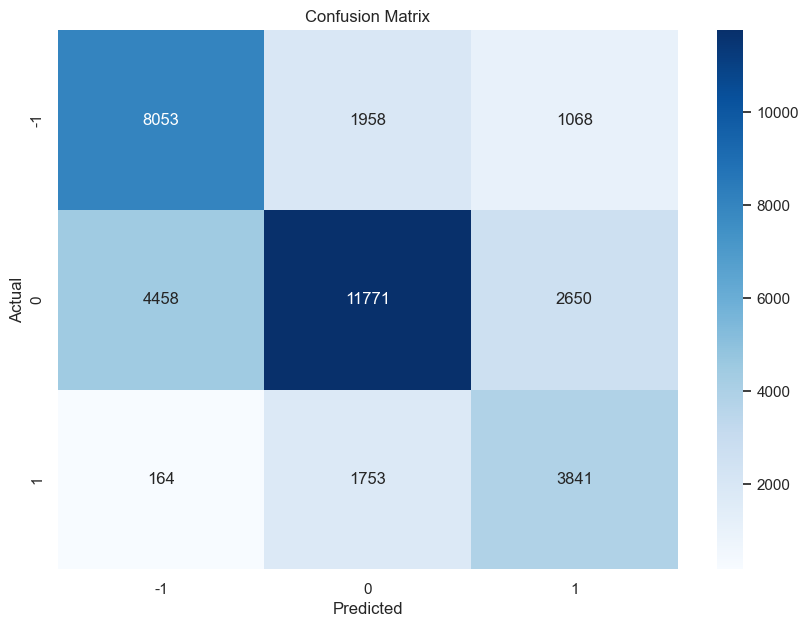

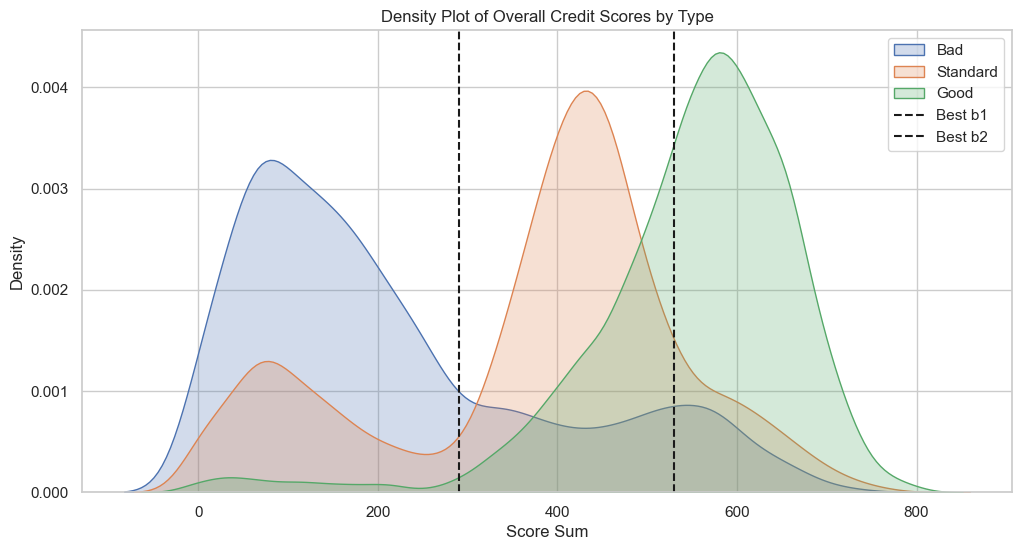

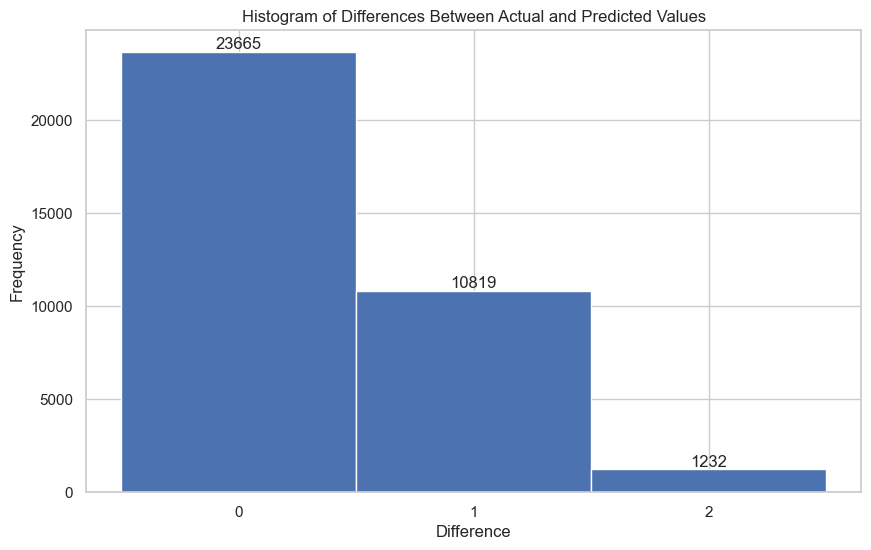

Mean Credit_Score_Num for bins_Interest_Rate:
bins_Interest_Rate
(0.999, 5.0]      0.273763
(5.0, 7.0]        0.170876
(7.0, 9.0]        0.117999
(9.0, 12.0]       0.168442
(12.0, 15.0]     -0.137763
(15.0, 17.0]     -0.302072
(17.0, 20.0]     -0.303214
(20.0, 24.0]     -0.658194
(24.0, 30.0]     -0.634856
(30.0, 5797.0]   -0.495633
Name: Credit_Score_Num, dtype: float64


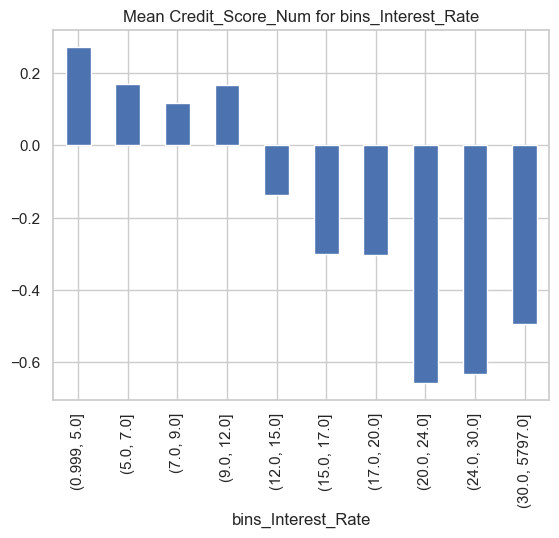

In [37]:
model = CreditScoreModel('Data/train-2.csv')
model.columns_to_process_num = ['Interest_Rate'] # Histogramas
model.run_full_analysis() # Accuracy modelo, graficas de densidad, e histograma de las diferencias entre las variables predichas y las reales